# Hit pattern for one event

(author: B.Paetsch, updated: 29.06.2020)

For a more precise interaction position reconstruction, the average of multiple PMTs seeing a significant signal is taken for the x- and y-position. Therefore the channellist in the waveform reader is moified, so that we now get a list with each PMT and its lowest adc value that contribute to the recorded signal. Here we look at the hit pattern of the TOP and BOTTOM PMTs for one event. I chose Event 4 for Rn220 and NG, because this one shows nicely two signals (one S1 and one S2).

In [81]:
import Zip
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time, sys, pickle, math
from IPython.display import clear_output

# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# for reading the ini file
from configparser import ConfigParser, ExtendedInterpolation
config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
config.optionsxform = str
config.read('xenon1t.ini')

ch_top = eval(config['DEFAULT']['channels_top'])
ch_bottom = eval(config['DEFAULT']['channels_bottom'])
gain = eval(config['DEFAULT']['gains'])

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [93]:
"""take gains into account for each adc value"""
"""the channellist is modified!!!"""
def myFunc(e):
    return e["adc_corrected"]

# A waveform reader function
def Waveform(raw,eventnr):
    event = raw.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    counter = False
    first = True
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        if ch in ch_top:  #only top PMTs
        #if ch in ch_bottom:  #only bottom PMTs    
            i = np.zeros(n_channels, dtype = int)
            for adc in p.raw_data:
                if gain[ch]!=0:
                    adc_corrected = 16382 - (16382 - adc)/gain[ch]*4911399 #corrected by relative gain
                else:
                    adc_corrected = 0 #np.inf
                #print("not corrected: ", adc, "corrected: ",adc_corrected)
                try:
                #Add the ADC value to the appropriate channel array
                    #ts[ch][p.left + i[ch]] = adc #(not corrected)
                    ts[ch][p.left + i[ch]] = adc_corrected
                    i[ch] = i[ch] + 1
                except IndexError:
                        counter = True
                        
                #Append all significant main channels to the list with their adc_corrected value
                if adc_corrected < 15000 and ch in det_ch['tpc']:   
                    #if it isn't in list, append
                    if first or len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
                        entry = {'channel': ch, 'adc_corrected': adc_corrected}
                        channellist.append(entry)
                        first = False
                    #if it is already in list, check whether adc value is now lower, if so take as new value    
                    else:                      
                        ind = channellist.index(list(filter(lambda value:value["channel"]==ch,channellist))[0])
                        if channellist[ind]['adc_corrected']>adc_corrected:
                            channellist[ind]['adc_corrected']=adc_corrected
                
                #Check which channel is the minimum channel
                if adc_corrected!=0 and adc_corrected < adcmin:
                    adcmin = adc_corrected
                    minchannel = ch
                if ch in channellist:
                    print(ch)
                
    #Sort by highest adc value
    channellist.sort(key= myFunc) #["adc_corrected"])
    return t, ts, channellist, minchannel, counter

In [99]:
(t, ts, channellist, minchannel, counter) = Waveform(Rn220,4)

In [100]:
print(minchannel)
print(len(channellist))
#print(channellist)
list(filter(lambda value:value["channel"]==minchannel,channellist))

66
117


[{'adc_corrected': -21788.236854275099, 'channel': 66}]

In [101]:
#adc_corrected, x, y, for each PMT for one event
xhist = []
yhist = []
adchist = np.array([])
for ch in ch_top:
#for ch in ch_bottom:
    pmt = eval(config['DEFAULT']['pmts'])
    x = pmt[ch]['position']['x']
    y = pmt[ch]['position']['y']
    xhist.append(x)
    yhist.append(y)
    
    if len(list(filter(lambda value:value["channel"]==ch,channellist)))==0:
        adchist = np.append(adchist,0)
    else:
        newlist = list(filter(lambda value:value["channel"]==ch,channellist))[0]
        adchist = np.append(adchist,newlist['adc_corrected']) 

Text(0,0.5,'y')

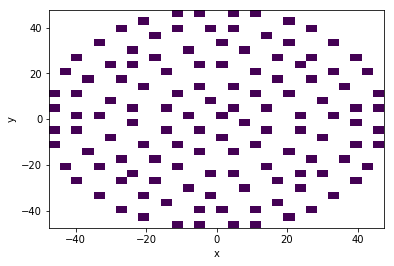

In [102]:
fig, ax = plt.subplots()
ax.hist2d(xhist,yhist, bins=(30,30), norm=mpl.colors.LogNorm())
ax.set_xlabel("x")
ax.set_ylabel("y")

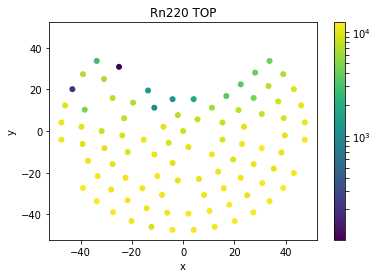

In [103]:
fig, ax = plt.subplots()
points = plt.scatter(xhist,yhist,c=adchist,norm=mpl.colors.LogNorm(),lw=0)
plt.colorbar(points)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Rn220 TOP")
fname = 'Rn_hitpatternTOP_corrected_Event4.png'
fig.savefig(fname, dpi = (200))

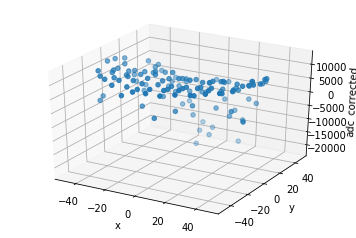

In [104]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D 
ax = plt.subplot(projection='3d')
ax.scatter(xhist, yhist, adchist)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('adc_corrected')

plt.show()
fname = 'Rn4TOP_3dScatter.png'
fig.savefig(fname, dpi = (200))